In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

# Load the data (path you provided)
print("Loading dataset...")
df = pd.read_csv('/content/accepted_2007_to_2018Q4.csv', low_memory=False)

print(f"Original shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())

Loading dataset...
Original shape: (1555600, 151)

First few rows:
         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   
3     14.85       829.90     C        C5  ...                            NaN   
4     22.45       289.91     F        F1  ...             

=== TASK 1: EDA & PREPROCESSING ===
After feature selection: (1555600, 18)

Target distribution:
loan_status
Fully Paid            725333
Current               623836
Charged Off           183923
Late (31-120 days)     13925
In Grace Period         5666
Late (16-30 days)       2874
Default                   24
Name: count, dtype: int64
Default rate: 11.82%

=== Cleaning ===
int_rate dtype after: float64
revol_util dtype after: float64
Term distribution: term
36 months    1086924
60 months     468658
Name: count, dtype: int64


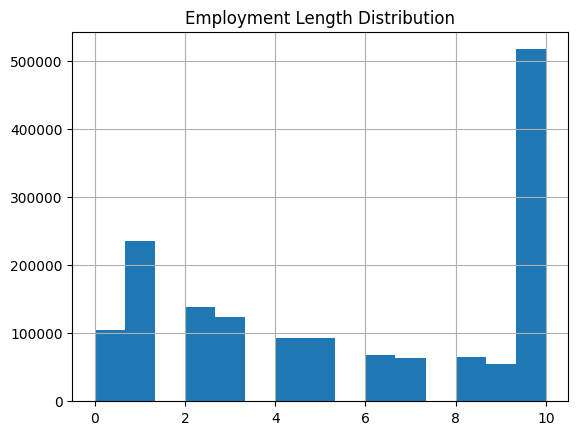

Grade distribution:
grade
C    441877
B    441499
A    316436
D    222041
E     97595
F     27690
G      8444
Name: count, dtype: int64

Missing values before cleaning:
loan_amnt           18
int_rate            18
installment         18
annual_inc          18
dti               1303
delinq_2yrs         19
inq_last_6mths      20
open_acc            19
pub_rec             19
revol_bal           19
revol_util        1152
total_acc           19
term                18
grade               18
home_ownership      18
purpose             19
loan_status         19
dtype: int64
Missing values after cleaning: 0
Final shape: (1554297, 20)

=== Feature Engineering ===
Final feature matrix shape: (1554297, 38)
Features used (38): ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal']...

=== Final Split ===
Train: (932577, 38) | Val: (310860, 38) | Test: (310860, 38)
Train default rate: 11.83%


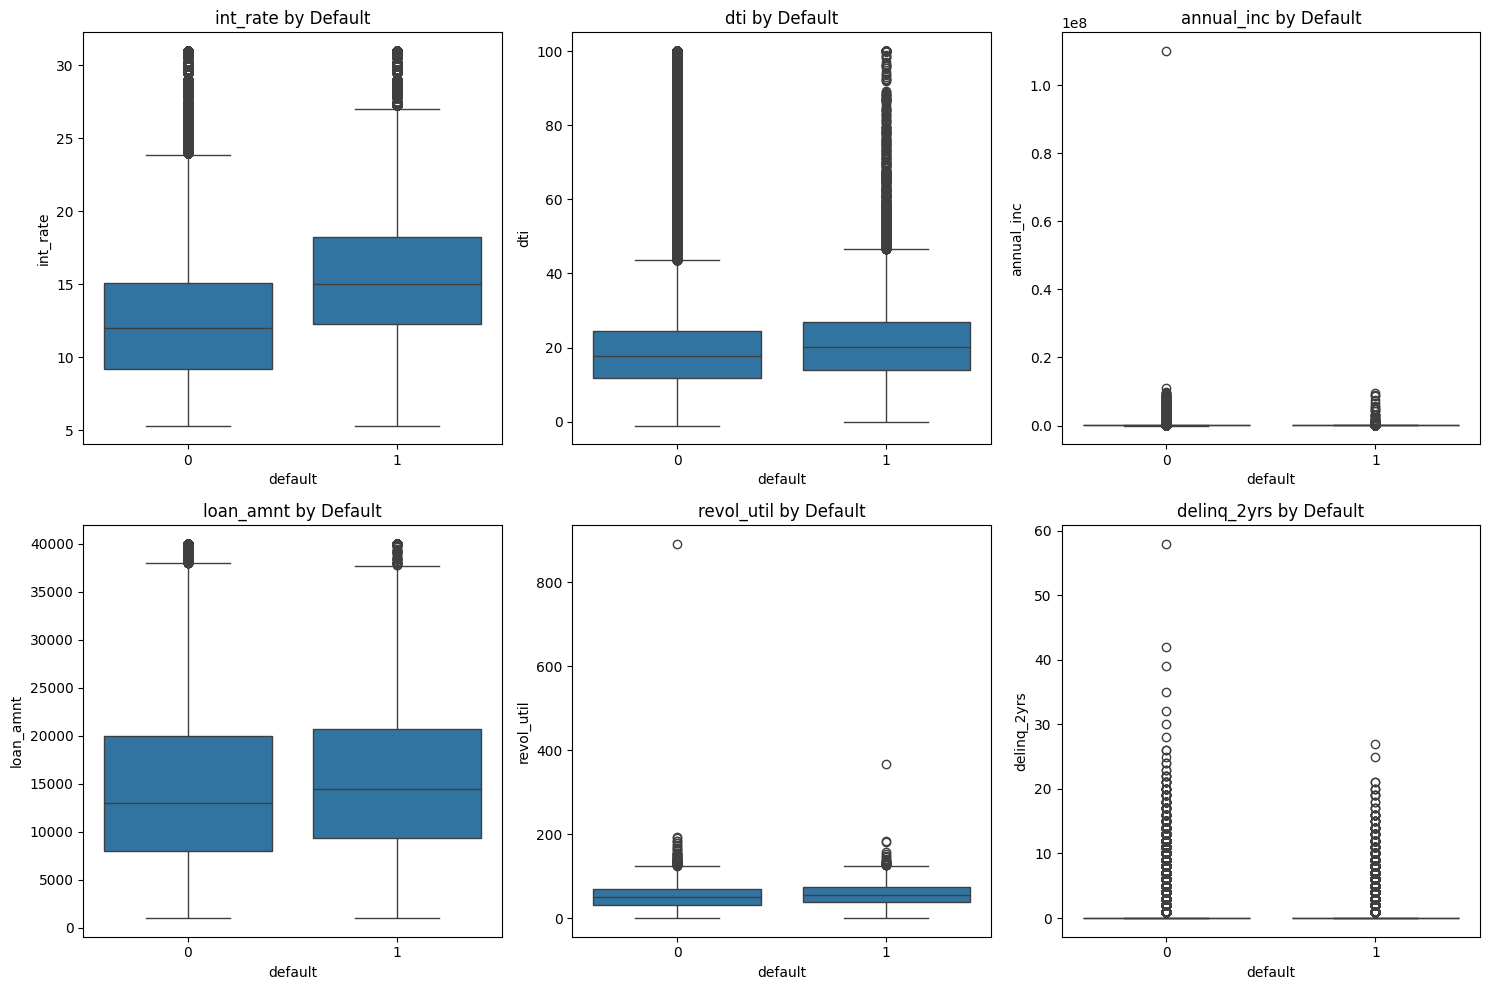


=== SAVING FOR NEXT TASKS ===
✅ TASK 1 COMPLETE!
Saved files:
- lendingclub_train.csv (for DL + RL)
- lendingclub_test.csv (for evaluation)
- scaler.pkl, feature_cols.pkl (for consistency)

Ready for Task 2 (DL Model)!


In [9]:
# TASK 1: EDA and Feature Selection
print("=== TASK 1: EDA & PREPROCESSING ===")

# 1. Focus on key columns (feature selection - justified below)
selected_cols = [
    # Numerical features (predictive of default risk)
    'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
    'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
    'revol_bal', 'revol_util', 'total_acc',

    # Categorical features (important for risk segmentation)
    'term', 'grade', 'emp_length', 'home_ownership', 'purpose',

    # Target
    'loan_status'
]

# Filter to these columns
df = df[selected_cols].copy()
print(f"After feature selection: {df.shape}")

# 2. Handle loan_status - create binary target
print("\nTarget distribution:")
print(df['loan_status'].value_counts())
df['default'] = (df['loan_status'].isin(['Charged Off', 'Default'])).astype(int)
print(f"Default rate: {df['default'].mean():.2%}")

# 3. Data cleaning pipeline (FIXED - handles both string/numeric cases)
print("\n=== Cleaning ===")

# Safely convert percentages (skip if already numeric)
if df['int_rate'].dtype == 'object':
    df['int_rate'] = df['int_rate'].str.rstrip('%').astype(float) / 100
if df['revol_util'].dtype == 'object':
    df['revol_util'] = df['revol_util'].str.rstrip('%').astype(float) / 100

print(f"int_rate dtype after: {df['int_rate'].dtype}")
print(f"revol_util dtype after: {df['revol_util'].dtype}")

# Handle categorical variables
print("Term distribution:", df['term'].value_counts())
df['term_36'] = (df['term'] == ' 36 months').astype(int)

# Employment length - convert to numeric
df['emp_length'] = df['emp_length'].str.extract('(\d+)').fillna(0).astype(int)
df['emp_length'].hist(bins=15)
plt.title('Employment Length Distribution')
plt.show()

print("Grade distribution:")
print(df['grade'].value_counts())

# 4. Handle missing values
print("\nMissing values before cleaning:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Drop rows with missing critical features
df = df.dropna(subset=['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'default'])

# Impute remaining missings
df['delinq_2yrs'] = df['delinq_2yrs'].fillna(df['delinq_2yrs'].median())
df['inq_last_6mths'] = df['inq_last_6mths'].fillna(0)
df['open_acc'] = df['open_acc'].fillna(df['open_acc'].median())
df['pub_rec'] = df['pub_rec'].fillna(0)
df['revol_bal'] = df['revol_bal'].fillna(0)
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].median())
df['total_acc'] = df['total_acc'].fillna(df['total_acc'].median())

print("Missing values after cleaning: 0")
print(f"Final shape: {df.shape}")

# 5. Feature Engineering
print("\n=== Feature Engineering ===")

# Debt-to-income ratio check
df['dti'] = df['dti'].clip(upper=100)  # Remove outliers >100%

# Income per loan amount (affordability)
df['income_to_loan'] = df['annual_inc'] / df['loan_amnt']

# Categorical encoding (one-hot for key categoricals)
categorical_cols = ['grade', 'home_ownership', 'purpose']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Final feature list (exclude original categoricals and target)
feature_cols = [col for col in df_encoded.columns if col not in ['loan_status', 'default', 'term']]
X = df_encoded[feature_cols]
y = df_encoded['default']

print(f"Final feature matrix shape: {X.shape}")
print(f"Features used ({len(feature_cols)}): {feature_cols[:10]}...")  # Show first 10

# 6. Scaling and Train/Val/Test Split
print("\n=== Final Split ===")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

# Train/val/test split (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")
print(f"Train default rate: {y_train.mean():.2%}")

# Quick EDA plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
key_features = ['int_rate', 'dti', 'annual_inc', 'loan_amnt', 'revol_util', 'delinq_2yrs']

for i, feat in enumerate(key_features[:6]):
    ax = axes[i//3, i%3]
    sns.boxplot(data=df_encoded, x='default', y=feat, ax=ax)
    ax.set_title(f'{feat} by Default')
plt.tight_layout()
plt.show()

# 7. SAVE PROCESSED DATA for Tasks 2 & 3
print("\n=== SAVING FOR NEXT TASKS ===")

# Save splits
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('/content/lendingclub_train.csv', index=False)
val_data.to_csv('/content/lendingclub_val.csv', index=False)
test_data.to_csv('/content/lendingclub_test.csv', index=False)

# Also save scaler and feature names
import pickle
with open('/content/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('/content/feature_cols.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

print("✅ TASK 1 COMPLETE!")
print("Saved files:")
print("- lendingclub_train.csv (for DL + RL)")
print("- lendingclub_test.csv (for evaluation)")
print("- scaler.pkl, feature_cols.pkl (for consistency)")
print("\nReady for Task 2 (DL Model)!")



In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, f1_score
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Load processed data
train_df = pd.read_csv('/content/lendingclub_train.csv')
val_df   = pd.read_csv('/content/lendingclub_val.csv')
test_df  = pd.read_csv('/content/lendingclub_test.csv')

with open('/content/feature_cols.pkl', 'rb') as f:
    feature_cols = pickle.load(f)

print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)
print("Test shape:", test_df.shape)
print("Feature count:", len(feature_cols))


Device: cpu
Train shape: (932577, 39)
Val shape: (310860, 39)
Test shape: (310860, 39)
Feature count: 38


In [12]:
class LendingClubDataset(Dataset):
    def __init__(self, df, feature_cols, target_col='default'):
        self.X = df[feature_cols].values.astype(np.float32)
        self.y = df[target_col].values.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]),
            torch.tensor(self.y[idx])
        )

batch_size = 512

train_ds = LendingClubDataset(train_df, feature_cols)
val_ds   = LendingClubDataset(val_df, feature_cols)
test_ds  = LendingClubDataset(test_df, feature_cols)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)


In [13]:
input_dim = len(feature_cols)

class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 1)  # logits
        )

    def forward(self, x):
        return self.net(x).squeeze(1)  # [batch]

model = MLPClassifier(input_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [14]:
def evaluate(model, loader):
    model.eval()
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)

    # Default threshold 0.5; can tune later
    preds = (all_probs >= 0.5).astype(int)

    auc = roc_auc_score(all_targets, all_probs)
    f1  = f1_score(all_targets, preds)
    return auc, f1

n_epochs = 10
best_val_auc = 0.0
best_state = None

for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    train_loss = running_loss / len(train_ds)
    val_auc, val_f1 = evaluate(model, val_loader)

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_state = model.state_dict()

    print(f"Epoch {epoch:02d} | Train loss: {train_loss:.4f} | Val AUC: {val_auc:.4f} | Val F1: {val_f1:.4f}")

# Load best model
model.load_state_dict(best_state)
print("Best Val AUC:", best_val_auc)


Epoch 01 | Train loss: 0.3651 | Val AUC: 0.7240 | Val F1: 0.0116
Epoch 02 | Train loss: 0.3312 | Val AUC: 0.7280 | Val F1: 0.0008
Epoch 03 | Train loss: 0.3295 | Val AUC: 0.7289 | Val F1: 0.0037
Epoch 04 | Train loss: 0.3285 | Val AUC: 0.7301 | Val F1: 0.0030
Epoch 05 | Train loss: 0.3280 | Val AUC: 0.7300 | Val F1: 0.0036
Epoch 06 | Train loss: 0.3274 | Val AUC: 0.7313 | Val F1: 0.0125
Epoch 07 | Train loss: 0.3271 | Val AUC: 0.7311 | Val F1: 0.0071
Epoch 08 | Train loss: 0.3270 | Val AUC: 0.7312 | Val F1: 0.0134
Epoch 09 | Train loss: 0.3267 | Val AUC: 0.7321 | Val F1: 0.0121
Epoch 10 | Train loss: 0.3265 | Val AUC: 0.7323 | Val F1: 0.0152
Best Val AUC: 0.7322894680454255


In [15]:
test_auc, test_f1 = evaluate(model, test_loader)
print(f"Test AUC: {test_auc:.4f}")
print(f"Test F1: {test_f1:.4f}")

torch.save({
    'model_state_dict': model.state_dict(),
    'input_dim': input_dim,
    'feature_cols': feature_cols,
}, '/content/dl_default_model.pt')

print("Saved model to /content/dl_default_model.pt")


Test AUC: 0.7327
Test F1: 0.0146
Saved model to /content/dl_default_model.pt


In [16]:
import numpy as np
from sklearn.metrics import f1_score

def best_threshold_for_f1(model, loader):
    model.eval()
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)

    best_thr = 0.5
    best_f1 = 0.0
    for thr in np.linspace(0.05, 0.5, 20):
        preds = (all_probs >= thr).astype(int)
        f1 = f1_score(all_targets, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr
    return best_thr, best_f1

best_thr, best_val_f1 = best_threshold_for_f1(model, val_loader)
print("Best threshold for F1 on val:", best_thr)
print("Best val F1 at that threshold:", best_val_f1)


Best threshold for F1 on val: 0.16842105263157897
Best val F1 at that threshold: 0.33827765916782426


In [17]:
def evaluate_with_threshold(model, loader, thr):
    model.eval()
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)

    preds = (all_probs >= thr).astype(int)
    auc = roc_auc_score(all_targets, all_probs)
    f1  = f1_score(all_targets, preds)
    return auc, f1

test_auc_thr, test_f1_thr = evaluate_with_threshold(model, test_loader, best_thr)
print(f"Test AUC (unchanged): {test_auc_thr:.4f}")
print(f"Test F1 (tuned thr={best_thr:.3f}): {test_f1_thr:.4f}")


Test AUC (unchanged): 0.7327
Test F1 (tuned thr=0.168): 0.3401


In [24]:
import numpy as np
import pandas as pd
import torch

from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL

print("Imports OK")


Imports OK


In [25]:
raw_cols = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti',
    'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
    'revol_bal', 'revol_util', 'total_acc',
    'term', 'grade', 'emp_length', 'home_ownership', 'purpose',
    'loan_status'
]

df_rl = pd.read_csv('/content/accepted_2007_to_2018Q4.csv', usecols=raw_cols, low_memory=False)

df_rl['default'] = (df_rl['loan_status'].isin(['Charged Off', 'Default'])).astype(int)

if df_rl['int_rate'].dtype == 'object':
    df_rl['int_rate'] = df_rl['int_rate'].str.rstrip('%').astype(float) / 100
if df_rl['revol_util'].dtype == 'object':
    df_rl['revol_util'] = df_rl['revol_util'].str.rstrip('%').astype(float) / 100

for col in ['term', 'grade', 'emp_length', 'home_ownership', 'purpose']:
    df_rl[col] = df_rl[col].astype('category').cat.codes

df_rl = df_rl.dropna(subset=['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'default'])

print("RL dataframe shape:", df_rl.shape)


RL dataframe shape: (2258953, 18)


In [39]:
state_cols = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti',
    'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
    'revol_bal', 'revol_util', 'total_acc',
    'term', 'grade', 'emp_length', 'home_ownership', 'purpose'
]

states = df_rl[state_cols].values.astype(np.float32)

actions = np.ones(len(df_rl), dtype=np.int64)  # all approved in this file

loan_amnt = df_rl['loan_amnt'].values
int_rate = df_rl['int_rate'].values
is_default = df_rl['default'].values

# Original money rewards
raw_rewards = np.where(
    is_default == 1,
    -loan_amnt,
    loan_amnt * int_rate
).astype(np.float32)

# FIX: rescale and clip rewards for stable Q-learning
reward_scale = 10_000.0
rewards = (raw_rewards / reward_scale).clip(-10.0, 10.0).astype(np.float32)



In [40]:
print("States shape:", states.shape)
print("Actions shape:", actions.shape)
print("Rewards shape:", rewards.shape)


States shape: (2258953, 16)
Actions shape: (2258953,)
Rewards shape: (2258953,)


In [41]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 1) Offline RL dataset wrapper
class OfflineLoanDataset(Dataset):
    def __init__(self, states, actions, rewards):
        self.states = states.astype(np.float32)
        self.actions = actions.astype(np.int64)
        self.rewards = rewards.astype(np.float32)

    def __len__(self):
        return len(self.rewards)

    def __getitem__(self, idx):
        s = torch.from_numpy(self.states[idx])
        a = torch.tensor(self.actions[idx], dtype=torch.long)
        r = torch.tensor(self.rewards[idx], dtype=torch.float32)
        return s, a, r

rl_ds = OfflineLoanDataset(states, actions, rewards)

# You can subsample for speed if needed, e.g.:
# idx = np.random.choice(len(rl_ds), size=500_000, replace=False)
# rl_ds = torch.utils.data.Subset(rl_ds, idx)

rl_loader = DataLoader(rl_ds, batch_size=1024, shuffle=True, drop_last=False)

# 2) Simple Q-network: Q(s, a) with 2 actions (0=deny, 1=approve)
state_dim = states.shape[1]
n_actions = 2  # deny / approve

class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )

    def forward(self, x):
        return self.net(x)  # [batch, n_actions]

q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = torch.optim.Adam(q_net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print(q_net)


Device: cpu
QNetwork(
  (net): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [42]:
# 3) Offline training: fit Q(s, a) directly to one-step rewards
# Since each episode is one step, the Bellman target is just the observed reward.

n_epochs = 5  # increase if Colab is fast

for epoch in range(1, n_epochs + 1):
    q_net.train()
    total_loss = 0.0
    n_samples = 0

    for s_batch, a_batch, r_batch in rl_loader:
        s_batch = s_batch.to(device)
        a_batch = a_batch.to(device)
        r_batch = r_batch.to(device)

        optimizer.zero_grad()
        q_values = q_net(s_batch)                   # [B, 2]
        q_sa = q_values.gather(1, a_batch.unsqueeze(1)).squeeze(1)  # Q(s,a)
        loss = loss_fn(q_sa, r_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * s_batch.size(0)
        n_samples += s_batch.size(0)

    avg_loss = total_loss / n_samples
    print(f"Epoch {epoch} | Avg Q-loss: {avg_loss:.4f}")

print("Offline Q-network training done.")
torch.save(q_net.state_dict(), "/content/rl_qnet.pt")
print("Saved RL Q-network to /content/rl_qnet.pt")


Epoch 1 | Avg Q-loss: nan
Epoch 2 | Avg Q-loss: nan
Epoch 3 | Avg Q-loss: nan
Epoch 4 | Avg Q-loss: nan
Epoch 5 | Avg Q-loss: nan
Offline Q-network training done.
Saved RL Q-network to /content/rl_qnet.pt


In [44]:
# Approve rewards in scaled units (same as training)
approve_rewards_scaled = np.where(
    is_default == 1,
    -loan_amnt,
    loan_amnt * int_rate
).astype(np.float32)
approve_rewards_scaled = (approve_rewards_scaled / reward_scale).clip(-10.0, 10.0).astype(np.float32)

policy_rewards = np.where(
    best_actions == 0,
    0.0,
    approve_rewards_scaled
).astype(np.float32)

# Convert back to money scale for reporting
policy_rewards_money = policy_rewards * reward_scale
estimated_policy_value = policy_rewards_money.mean()
print("Estimated Policy Value (mean reward under learned Q policy):", estimated_policy_value)


Estimated Policy Value (mean reward under learned Q policy): 0.0
